# Chapter6. 模型评估与参数调优
模型性能的无偏估计

处理机器学习算法中常见问题

机器学习模型调优

使用不同的性能评估标准预测模型

In [1]:
%matplotlib inline

## 1. 基于流水线的工作流
这里主要介绍sklearn中的Pipline类，它使得我们可以拟合出包含任意多个处理步骤的模型，并将模型用于数据预测
### a. 加载威斯康星乳腺癌数据集
此数据集包含569个恶性或良性肿瘤样本，前两列存储了样本ID和肿瘤属性（M恶性，B良性），剩余列包含了细胞核特征。

In [3]:
import pandas as pd
import urllib

try:
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                     '/breast-cancer-wisconsin/wdbc.data', header=None)
except urllib.error.URLError:
    df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                     'python-machine-learning-book/master/code/'
                     'datasets/wdbc/wdbc.data', header=None)
    
print('rows, columns:', df.shape)
df.head()

rows, columns: (569, 32)


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
# 使用LabelEncoder类可以将类标从原始字符串表示（M or B）转换成整数
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
# 输出示例
le.transform(['M', 'B'])

array([1, 0])

`random_state`参数可以设置每次划分数据集时的方式。如果设置为`None`，那么每次产生的随机数都不相同，导致划分出的训练集和测试集中样本也不相同，如果设置为固定值，那么每次产生的随机数序列就相同，得到的训练集和测试集的样本也相同。

In [63]:
# 分割数据集为测试集和训练集
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=1)

### b. 在流水线中集成数据转化及评估操作
通过前面的章节我们知道：出于性能优化的目的，许多算法需要将特征缩放到统一的范围，需要特征标准化处理，同时我们还想将乳腺癌数据集压缩到一个二维的子空间上。我们无需在数据集和测试集上分别进行模型拟合和数据转换，而是使用流水线将`StandardScaler`、`PCA`，以及`LogisticRegression`串联起来。

---
**关于LogisticRegression中的solver**
solver：优化算法选择参数，只有五个可选参数，即newton-cg,lbfgs,liblinear,sag,saga。默认为liblinear。solver参数决定了我们对逻辑回归损失函数的优化方法，有四种算法可以选择，分别是： 
- liblinear：使用了开源的liblinear库实现，内部使用了坐标轴下降法来迭代优化损失函数。
- lbfgs：拟牛顿法的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
- newton-cg：也是牛顿法家族的一种，利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数。
- sag：即随机平均梯度下降，是梯度下降法的变种，和普通梯度下降法的区别是每次迭代仅仅用一部分的样本来计算梯度，适合于样本数据多的时候。
- saga：线性收敛的随机优化算法的的变重。

---
总结： 
-   liblinear适用于小数据集，而sag和saga适用于大数据集因为速度更快。对于多分类问题，只有newton-cg,sag,saga和lbfgs能够处理多项损失，而liblinear受限于一对剩余(OvR)。啥意思，就是用liblinear的时候，如果是多分类问题，得先把一种类别作为一个类别，剩余的所有类别作为另外一个类别。一次类推，遍历所有类别，进行分类。<br>
-   newton-cg,sag和lbfgs这三种优化算法时都需要损失函数的一阶或者二阶连续导数，因此不能用于没有连续导数的L1正则化，只能用于L2正则化。而liblinear和saga通吃L1正则化和L2正则化。<br>
-   同时，sag每次仅仅使用了部分样本进行梯度迭代，所以当样本量少的时候不要选择它，而如果样本量非常大，比如大于10万，sag是第一选择。但是sag不能用于L1正则化，所以当你有大量的样本，又需要L1正则化的话就要自己做取舍了。要么通过对样本采样来降低样本量，要么回到L2正则化。<br>
-   从上面的描述，大家可能觉得，既然newton-cg, lbfgs和sag这么多限制，如果不是大样本，我们选择liblinear不就行了嘛！错，因为liblinear也有自己的弱点！我们知道，逻辑回归有二元逻辑回归和多元逻辑回归。对于多元逻辑回归常见的有one-vs-rest(OvR)和many-vs-many(MvM)两种。而MvM一般比OvR分类相对准确一些。郁闷的是liblinear只支持OvR，不支持MvM，这样如果我们需要相对精确的多元逻辑回归时，就不能选择liblinear了。也意味着如果我们需要相对精确的多元逻辑回归不能使用L1正则化了。

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(solver='lbfgs', random_state=1))])

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))
y_pred = pipe_lr.predict(X_test)

Test Accuracy: 0.947


## 2. 使用k折交叉验证评估模型性能
- holdout 交叉验证（holdout cross-validation）
- k折交叉验证（k-fold cross-validation）

### a. holdout方法
将数据集划分成训练集、验证集和测试集。在训练集上进行不同模型的拟合，模型在验证集上的表现作为选择标准，使用测试集作为最终模型性能评估的标准。

holdout方法的缺点在于，它对训练集和验证集的划分方式是敏感的。所以就有了k折交叉验证

### b. k折交叉验证
在k折交叉验证中，我们不重复随机地将训练集划分为$k$个，$k-1$个用于训练，剩余的用于测试。

通常来说选取$k=10$作为划分标准，如果训练数据集较小，那么就有必要增大$k$值，这样每次就会有更多的数据参加训练，这样可以得到较小的偏差，但是$k$值的增加会导致迭代次数增加，交叉验证算法时间延长，同时由于各训练块之间数据相似度高，导致方差较高；如果训练数据集较大，那么可以选择较小的$k$值。

分层k折交叉验证在每一折中都保持了原模型中类别的比例，而标准的k折交叉验证则没有处理类别比例。

In [69]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# 使用分层k折交叉验证分割数据集
# kfold包含两个array，第一个是k-1折训练集的样本标记（也就是第几个样本），第二个是验证集的样本标记
# 使用y_train作为分类标准，将训练集分割成等比例的。
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    # 拟合样本
    pipe_lr.fit(X_train[train], y_train[train])
    # 使用验证集评估模型准确率
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    # bincount统计各类标出现的次数
    print("Fold: %s, Class dist.: %s, Acc: %.3f" % (k+1, 
          np.bincount(y_train[train]), score))

print("\nCV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [224 134], Acc: 0.950
Fold: 2, Class dist.: [224 134], Acc: 0.950
Fold: 3, Class dist.: [224 134], Acc: 0.975
Fold: 4, Class dist.: [224 134], Acc: 0.975
Fold: 5, Class dist.: [224 134], Acc: 1.000
Fold: 6, Class dist.: [224 134], Acc: 1.000
Fold: 7, Class dist.: [224 134], Acc: 1.000
Fold: 8, Class dist.: [224 134], Acc: 0.975
Fold: 9, Class dist.: [224 134], Acc: 0.975
Fold: 10, Class dist.: [225 135], Acc: 1.000

CV accuracy: 0.980 +/- 0.019


可以看出所有“折”里`Class dist`的正负样本比例相同，这就是分层k折交叉验证的处理方法。

上面我们自己实现了交叉验证的评估，也可以使用sklearn中的交叉验证评分方法：

In [68]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)

print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.95  0.95  0.975 0.975 1.    1.    1.    0.975 0.975 1.   ]
CV accuracy: 0.980 +/- 0.019


`cross_val_score`有一个极为有用的特点，在处理不同分块的时候可以将它们分布到多个CPU核心上进行处理，具体实现就是`n_jobs`选项，它可以指明使用的CPU核心个数。`n_jobs=-1`使用所有的CPU核心进行计算。

## 3. 通过学习及验证曲线来调试算法
学习曲线（Learning Curve）

调试曲线（Validation Curve）

### a. 使用学习曲线判定偏差和方差
学习曲线绘制的是样本大小和训练准确率、测试准确率之间的关系。

`learning_curve`中`train_sizes`选项可以设置对训练集的分割方法，`np.linspace(0.1, 1.0, 10)`就代表从训练样本的10%开始，依次递增，直到使用所有的训练集样本进行训练。其中k折交叉验证也在该样本上进行。

它返回三个数组，第一个是每次用于训练的样本数量，第二个是对应样本数量所得到的训练集准确率，第三个是对应样本数量的交叉验证集准确率。

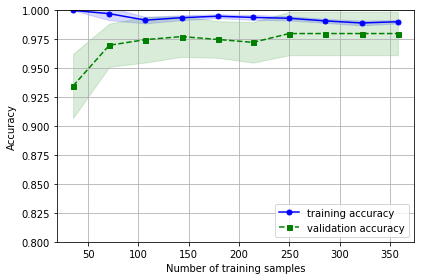

In [67]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 设置流水线，使用l2正则，优化算法可以选择多种
# liblinear, lbfgs, newton-cg, etc.
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', 
                                               solver='liblinear', random_state=0))])

train_sizes, train_scores, test_scores = \
                learning_curve(estimator=pipe_lr, 
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

# 求对应训练样本量下，10折交叉验证得到的训练集准确率平均值
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
# 求对应训练样本量下，10折交叉验证得到的验证集准确率平均值
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

# fill_between方法可以绘制范围曲线，表示在确定横坐标的情况下，纵坐标波动的范围。
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

### b. 使用验证曲线判定过拟合与欠拟合
验证曲线绘制的是准确率和模型参数之间的关系，例如LogisticRegression中正则化参数和准确率的关系。

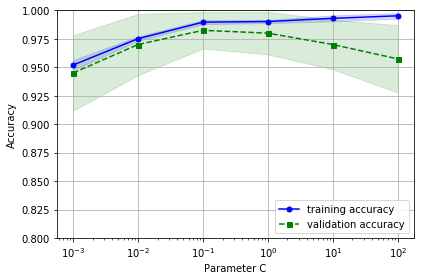

In [66]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# 和学习曲线类似，返回的是不同参数设置下的准确率
# param_name选项后面跟的是学习器名称加参数名，中间用双下划线隔开
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name='clf__C',
                                             param_range=param_range,
                                             cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue',)

plt.plot(param_range, test_mean,
         color='green', marker='s',
         linestyle='--', markersize=5,
         label='validation accuracy')

plt.fill_between(param_range, test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

通过设置不同的正则化参数可以看到，C较小时模型欠拟合，C较大时模型过拟合，大约在C=0.1取最优。

## 4. 使用网格搜索调优机器学习模型
在机器学习中有两类参数：
- 通过训练数据学习得到的参数，如LogisticRegression中的回归系数；
- 学习算法中需要优化的参数，如LogisticRegression中的正则化参数；

后者就是调优参数，也称为超参。网格搜素（grid search）可以通过寻找最优的超参组合来进一步提升模型性能。
### a. 使用网格搜素调优超参
网格搜素使用暴力穷尽的方法进行搜索，并计算每个组合对模型性能的影响。

In [89]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]

# 这里有两种学习器，线性的SVM和非线性的SVM
# 线性的SVM只有一个超参就是正则化参数；非线性的SVM有两个，多了一个rbf的gamma
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
                 {'clf__C': param_range, 
                  'clf__gamma': param_range, 
                  'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9849246231155779
{'clf__C': 1000.0, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}


In [72]:
# 输出最优模型，并在独立的测试集上进行测试准确率
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print("Test accuracy: %.3f" % clf.score(X_test, y_test))

Test accuracy: 0.965


### b. 通过嵌套交叉验证选择算法
如果要在不同的机器学习算法中间做出选择，就需要嵌套交叉验证方法。

在嵌套交叉验证的外围循环中，我们将数据划分为训练块和测试块；而在用于模型选择的内部循环中，我们则使用这些训练进行k折交叉验证。完成模型选择后，使用测试数据进行模型性能评估。

In [85]:
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid = param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV accuracy: 0.977 +/- 0.019


In [86]:
scores

array([0.95      , 0.9875    , 1.        , 0.9875    , 0.96153846])

输出`scores`可以看出它包含了5个值，分别是第二次进行交叉验证评估时得到的准确率，而在每折交叉验证的过程中，都在划分的训练数据集上进行网格搜索来调优超参，网格搜索也是用2折交叉验证来评估模型性能，将最优模型返回，作为外围循环每折的输入。

In [87]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print("CV accuracy: %.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

CV accuracy: 0.930 +/- 0.020


## 5. 不同的性能评价指标
### a. 混淆矩阵
| Class    | P        | N      |
|----------|---------:|-------:|
| P        | TP       | FN     |
| N        | FP       | TN     | 


In [90]:
# 导入混淆矩阵
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
# 根据模型进行预测
y_pred = pipe_svc.predict(X_test)
# 输出混淆矩阵
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[106   2]
 [  3  60]]


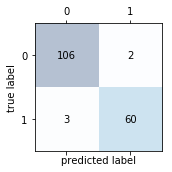

In [91]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.tight_layout()
plt.show()

### b. 优化分类模型的准确率和召回率
预测误差（ERR）：
$$ERR=\frac{FP+FN}{FP+FN+TP+TN}$$
准确率（ACC）：
$$ACC=\frac{TP+TN}{FP+FN+TP+TN}$$

当类别数量不均衡时，可以用真正率（TPR）和假正率（FPR）来衡量性能。<br>
假正率就是预测为假实际为真的样本在所有预测为假的样本中的比例

$$FPR=\frac{FP}{FP+TN}$$

真正率定义如下，就是预测为真实际也为真的样本在所有预测为真的样本中比例：

$$TPR=\frac{TP}{FN+TP}$$

查准率（PRE）：

$$PRE=\frac{TP}{TP+FP}$$

召回率（REC）：
$$REC=TPR=\frac{TP}{FN+TP}$$

F1分数：
$$F1=2\frac{PRE\times REC}{PRE+REC}$$


In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Recall: %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("F1: %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.968
Recall: 0.952
F1: 0.960


我们还可以在网格搜索中使用其他的标准作为性能评估方式。例如使用F1值：

In [94]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'clf__C': c_gamma_range,
               'clf__kernel': ['linear']},
              {'clf__C': c_gamma_range,
               'clf__gamma': c_gamma_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861267119913291
{'clf__C': 0.1, 'clf__kernel': 'linear'}


### c. 绘制受试者工作特征曲线（reciver operator characteristic，ROC）
ROC是基于模型假正率和真正率性能指标进行分类模型选择的工具。ROC对角线可以理解为随机猜测，如果分类器性能在对角线以下，那么性能就比随机猜测还差。对于完美的分类器来说，真正率为1，假正率为0，ROC就是横轴0和纵轴1组成的折线。所以通过ROC曲线，我们就可以计算ROC线下区域（area under the curve, AUC）来刻画分类模型性能。

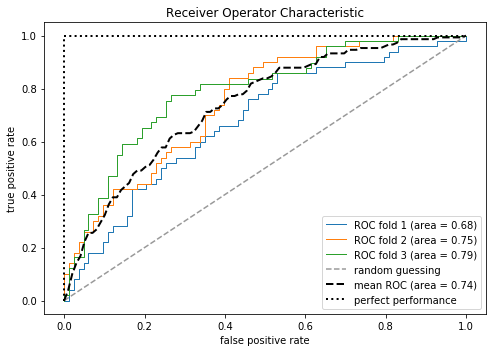

In [101]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2',
                                               solver='liblinear',
                                               random_state=0,
                                               C=100.0))])
# 选择两个特征进行测试
X_train2 = X_train[:, [4, 14]]


cv = list(StratifiedKFold(n_splits=3,
                          random_state=1).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    
    # predict_proba返回的是一个n行k列的数组， 
    # 第i行第j列上的数值是模型为1预测第i个预测样本为某个标签的概率，并且每一行的概率和
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    # 计算假正率和真正率
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    # interp是插值函数
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, 
             label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
# 绘制对角线，随机猜测的结果
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

如果只对ROC和AUC分数感兴趣，可以直接使用`roc_auc_score`函数。

In [102]:
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_labels = pipe_lr.predict(X_test[:, [4, 14]])
y_probas = pipe_lr.predict_proba(X_test[:, [4, 14]])[:, 1]

from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_probas))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_labels))

ROC AUC: 0.775
Accuracy: 0.719
